In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
#from utils.labels import trainId2label
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
import os

# Set base directory dynamically
CITYSCAPES_DIR = os.path.abspath("../data")  # Ensures the path is absolute

# Define image and label paths
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")

# Constants
LIMIT_IMAGES = 2975  # Number of images to sample
MAX_PIXELS = 1000000  # Max number of pixels to process
LABEL_ID = 7  # Road label


In [3]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [4]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [5]:
def preprocess_data_with_patches(image_label_pairs, patch_size, max_pixels=MAX_PIXELS, label_Id=LABEL_ID):
    """Extract pixel patches and labels for training."""
    X = []  # Patches centered around sampled pixels
    y = []  # Binary labels (road or not road)
    total_pixels = 0
    pixels_per_image = max_pixels // LIMIT_IMAGES // 2
    patch_radius = patch_size // 2  # Radius to define the patch
    
    for image_path, label_path in tqdm.tqdm(image_label_pairs):
        # Load RGB image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # Load label image
        label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)

        # Pad image and label to handle edge cases
        padded_image = cv2.copyMakeBorder(
            image, patch_radius, patch_radius, patch_radius, patch_radius, cv2.BORDER_REFLECT
        )
        padded_label = cv2.copyMakeBorder(
            label_img, patch_radius, patch_radius, patch_radius, patch_radius, cv2.BORDER_REFLECT
        )
        
        # Flatten label image into 1D array
        label_pixels = label_img.flatten()
        
        # Filter for road (TrainId = 7) and not-road
        road_mask = (label_pixels == label_Id)
        not_road_mask = ~road_mask

        # Create subsets for road and not-road pixels
        road_indices = np.where(road_mask)[0]
        not_road_indices = np.where(not_road_mask)[0]
        
        # Randomly sample pixel indices
        sampled_road_indices = np.random.choice(
            road_indices, min(pixels_per_image, len(road_indices)), replace=False
        )
        sampled_not_road_indices = np.random.choice(
            not_road_indices, min(pixels_per_image, len(not_road_indices)), replace=False
        )

        # Combine sampled indices
        sampled_indices = np.concatenate([sampled_road_indices, sampled_not_road_indices])
        sampled_labels = np.concatenate([
            [1] * len(sampled_road_indices), 
            [0] * len(sampled_not_road_indices)
        ])

        for idx, label in zip(sampled_indices, sampled_labels):
            # Convert 1D index to 2D (row, col)
            row, col = divmod(idx, label_img.shape[1])
            # Adjust for padding
            row += patch_radius
            col += patch_radius
            # Extract patch
            patch = padded_image[row - patch_radius : row + patch_radius + 1,
                                 col - patch_radius : col + patch_radius + 1, :]
            # Append patch and label
            X.append(patch)
            y.append(label)
            
            total_pixels += 1
            if total_pixels >= max_pixels:
                break
        if total_pixels >= max_pixels:
            break

    

    return np.array(X), np.array(y)


In [6]:
# Get image-label pairs
image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)

X, y = preprocess_data_with_patches(image_label_pairs, patch_size=16, max_pixels=MAX_PIXELS)


100%|██████████| 2975/2975 [04:31<00:00, 10.94it/s]


In [7]:
print(f"Processed {len(X)} pixels")
print(f"Number of road pixels: {np.sum(y)}")
print(f"Number of not road pixels: {len(y) - np.sum(y)}")

Processed 992712 pixels
Number of road pixels: 492912.0
Number of not road pixels: 499800.0


In [8]:
# Normalize RGB values
X = X / 255.0  # Scale RGB to [0, 1]

In [9]:
# Model training pipeline
import tensorflow as tf
from tensorflow.keras import layers, models

In [18]:
def build_patch_classifier(patch_size):
    model = models.Sequential([
        layers.Input(shape=(patch_size+1, patch_size+1, 3)),  # Patch input (H x W x Channels)
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output: road (1) or not road (0)
    ])
    return model


In [19]:
model = build_patch_classifier(16)
model.load_weights('road_patch_classifier.h5')


In [20]:
# Build and compile the model
# model = build_patch_classifier(patch_size=16)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 17, 17, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [22]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=55)

In [23]:
# Train the model
#model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))

In [24]:
#model.save("road_patch_classifier.h5")

6205/6205 [==============================] - 21s 1ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     99695
         1.0       0.84      0.93      0.88     98848

    accuracy                           0.88    198543
   macro avg       0.88      0.88      0.87    198543
weighted avg       0.88      0.88      0.87    198543



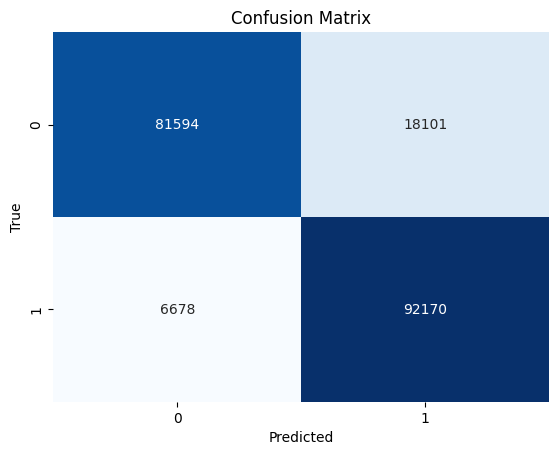

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)

# Print classification report
print(classification_report(y_val, y_pred))

# Plot confusion matrix with updated color palette
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)  # Using the 'Blues' color palette
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

6205/6205 [==============================] - 7s 1ms/step


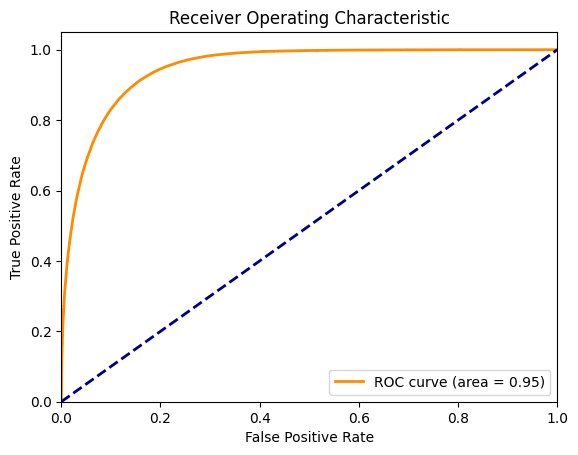

In [26]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_val)

fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


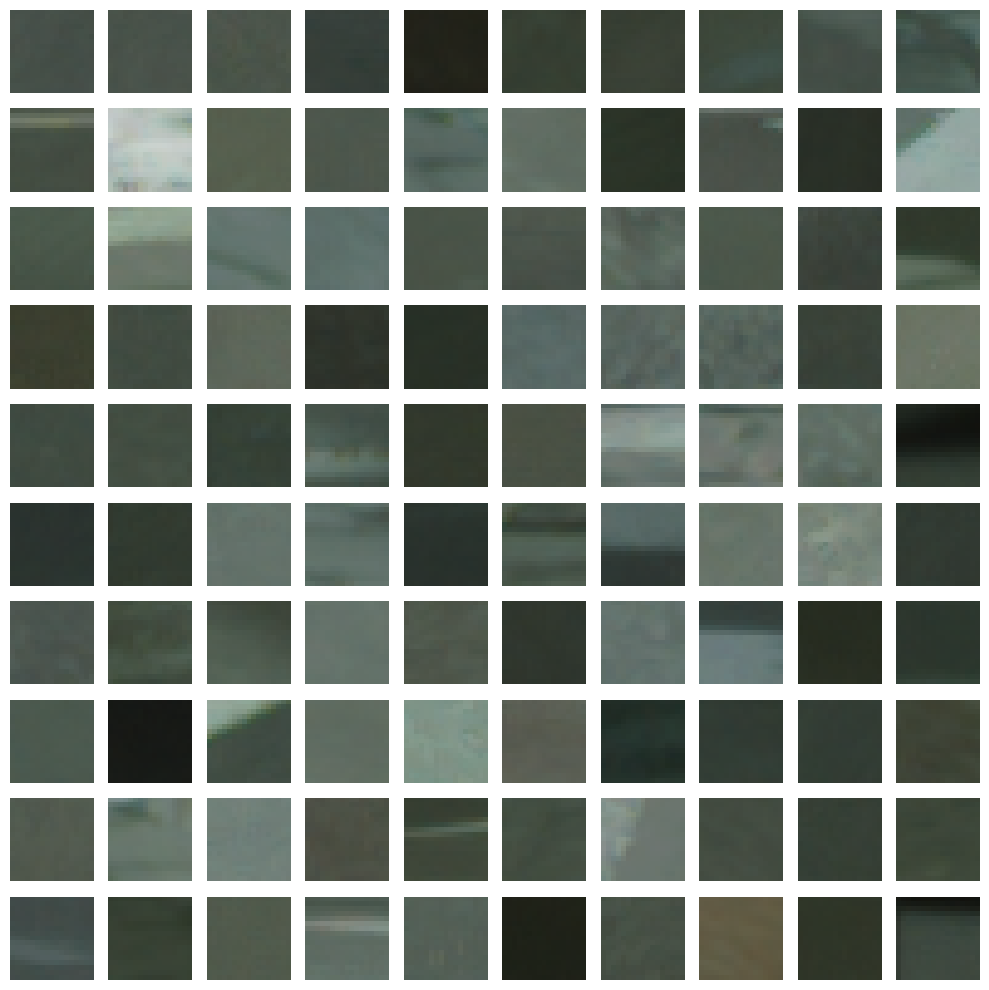

In [32]:
# plot 100 patches of road class 
road_patches = X_val[y_val == 1]
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(road_patches[i])
    ax.axis('off')
plt.tight_layout()
plt.show()



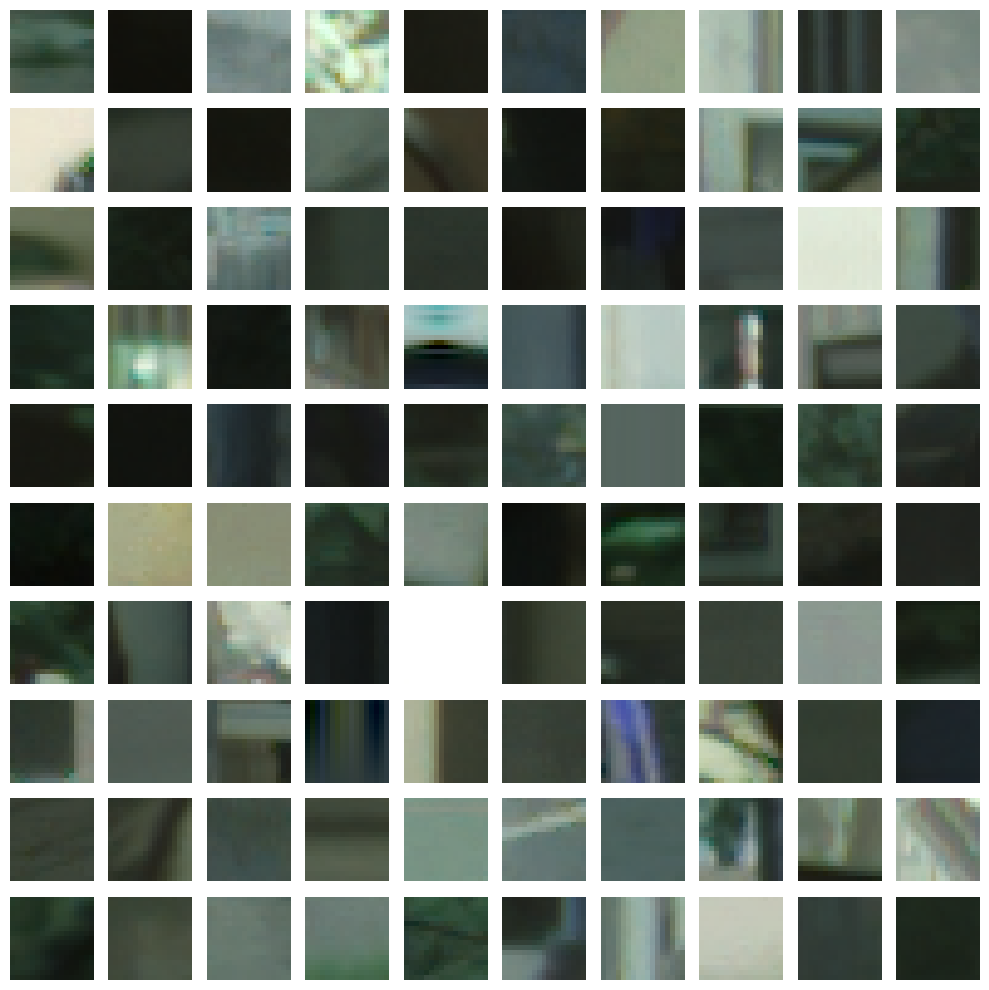

In [33]:
# plot 100 patches of non road class 
non_road_patches = X_val[y_val == 0]
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(non_road_patches[i])
    ax.axis('off')
plt.tight_layout()
plt.show()